In [1]:
# %reset -f

# Imports + Codebook configuration

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from sklearn.datasets import fetch_openml
from IPython.display import display, HTML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import  RidgeClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier



rcParams['figure.figsize'] = (10, 6)
rcParams['legend.fontsize'] = 16
rcParams['axes.labelsize'] = 16


# Loading and random printing

In [2]:
# Load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Print the size of the data and labels
print('Data size: %d, %d' % (X.shape[0],X.shape[1]))
print('Labels size: %d' % (y.shape))

# Convert to numpy arrays
X = X.to_numpy()
y = y.to_numpy()

# # Show some random training samples
# num_random_samples = 4
# random_samples = np.random.randint(0, X.shape[0], num_random_samples)
# for random_sample_i in random_samples:
#     imi = X.iloc[random_sample_i,:].values.reshape(28,28)
#     fig, ax1 = plt.subplots(1,1)
#     figtitle = "training image #%d" % random_sample_i
#     ax1.imshow(imi, cmap=plt.get_cmap('gray'))
#     ax1.set_title(figtitle)
#     plt.show()
#     print('Label: %s' % (y[random_sample_i]))

Data size: 70000, 784
Labels size: 70000


# Split

In [3]:
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size = 0.1, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, test_size = 0.1, random_state=7)

print('# training samples: ', X_train.shape[0])
print('# validation samples: ', X_val.shape[0])
print('# test samples: ', X_test.shape[0])

# training samples:  56700
# validation samples:  6300
# test samples:  7000


# Scaling

In [4]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)          
X_test_scaled = scaler.transform(X_test) 
X_train_and_val_scaled = scaler.transform(X_train_and_val)       




Scaling the data should help to converge the models faster.

# K-nn

In [6]:
k_neighbors = range(1, 10)

for k in k_neighbors: 
    # Define a knn classifier with the training data
    knn_clf = KNeighborsClassifier(n_neighbors=k)
    knn_clf.fit(X_train_scaled, y_train)

    # Start timer to report the time
    start_time = time.time()

    # Evaluate the model with the test split and print results
    acc_knn_clf = knn_clf.score(X_val_scaled, y_val)
    print(f"k={k} accuracy={acc_knn_clf * 100:.2f}%, time={time.time() - start_time:.1f}s")

k=1 accuracy=94.92%, time=3.2s
k=2 accuracy=94.24%, time=3.2s
k=3 accuracy=94.90%, time=3.1s
k=4 accuracy=94.70%, time=3.2s
k=5 accuracy=94.75%, time=3.3s
k=6 accuracy=94.49%, time=3.4s
k=7 accuracy=94.43%, time=3.4s
k=8 accuracy=94.29%, time=3.5s
k=9 accuracy=94.21%, time=3.5s


Different neighbors does not improve the accuracy

# K-NN + PCA

In [7]:
dims = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600]

# For several values of the k parameter
for dim in dims:
    
    pca = PCA(n_components=dim)
    X_train_pca_scaled = pca.fit_transform(X_train_scaled)
    X_val_pca_scaled = pca.transform(X_val_scaled)
    
    # Start timer to report the time
    start_time = time.time()

    # Define a knn classifier with the training data
    knn_clf = KNeighborsClassifier(n_neighbors=1)
    knn_clf.fit(X_train_pca_scaled, y_train)

    # Evaluate the model with the test split and print results
    acc_knn_clf = knn_clf.score(X_val_pca_scaled, y_val)
    print(f"dims after PCA={dim}, accuracy={acc_knn_clf * 100:.2f}%, time={time.time() - start_time:.1f} s")

dims after PCA=10, accuracy=90.21%, time=0.3 s
dims after PCA=20, accuracy=95.02%, time=0.4 s
dims after PCA=30, accuracy=95.65%, time=0.5 s
dims after PCA=40, accuracy=95.94%, time=0.5 s
dims after PCA=50, accuracy=96.00%, time=0.5 s
dims after PCA=60, accuracy=96.02%, time=0.6 s
dims after PCA=70, accuracy=95.90%, time=0.6 s
dims after PCA=80, accuracy=96.05%, time=0.7 s
dims after PCA=90, accuracy=96.05%, time=0.7 s
dims after PCA=100, accuracy=96.10%, time=0.8 s
dims after PCA=200, accuracy=95.40%, time=1.2 s
dims after PCA=300, accuracy=95.38%, time=1.7 s
dims after PCA=400, accuracy=95.14%, time=2.5 s
dims after PCA=500, accuracy=94.95%, time=2.8 s
dims after PCA=600, accuracy=95.00%, time=3.0 s


20 dimensions explain the 95% of accuracy of a K-nn model

# Gridsearch for k with 20 PCA components

In [7]:
pca = PCA(n_components=20)
X_train_and_val_pca_scaled = pca.fit_transform(X_train_and_val_scaled)


# Set up a parameter grid to search for the best k
param_grid = {'n_neighbors': list(range(1, 21))}

# Perform grid search with cross-validation
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_and_val_pca_scaled, y_train_and_val)

# Get the best number of neighbors
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal number of neighbors (k): {best_k}")

Optimal number of neighbors (k): 6


Optimal k=5

# K-nn with optimal k + PCA

In [9]:
n_components = [20, 30, 40, 50, 100]
for component in n_components:
    pca = PCA(n_components=component)
    X_train_pca_scaled = pca.fit_transform(X_train_scaled)
    X_val_pca_scaled = pca.transform(X_val_scaled)

    # Start timer to report the time
    start_time = time.time()
    # Define a knn classifier with the training data
    knn_clf = KNeighborsClassifier(n_neighbors=best_k)
    knn_clf.fit(X_train_pca_scaled, y_train)

    # Evaluate the model with the test split and print results
    acc_knn_clf = knn_clf.score(X_val_pca_scaled, y_val)
    print(f"K-nn (optimal k), PCA={component} components, accuracy={acc_knn_clf * 100:.2f}%, time={time.time() - start_time:.1f} s")


K-nn, PCA=20 components, accuracy=95.27%, time=0.5 s
K-nn, PCA=30 components, accuracy=95.83%, time=0.5 s
K-nn, PCA=40 components, accuracy=96.03%, time=0.6 s
K-nn, PCA=50 components, accuracy=96.17%, time=0.6 s
K-nn, PCA=100 components, accuracy=96.11%, time=0.9 s


# K-nn with all dimensions and optimal k

In [10]:
# Start timer to report the time
start_time = time.time()
# Define a knn classifier with the training data
knn_clf = KNeighborsClassifier(n_neighbors=best_k)
knn_clf.fit(X_train_scaled, y_train)

# Evaluate the model with the test split and print results
acc_knn_clf = knn_clf.score(X_val_scaled, y_val)
print(f"k-nn with k={best_k}, accuracy={acc_knn_clf * 100:.2f}%, time={time.time() - start_time:.1f} s")


k-nn with k=6, accuracy=94.49%, time=4.0 s


Poorer performance than without PCA

# Logistic Regression

In [11]:

# Start timer to report the time
start_time = time.time()

# Fit a logistic regression with scaled data
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_scaled, y_train)
acc_lr = lr.score(X_val_scaled, y_val)
print(f'Accuracy, logistic classifier: {acc_lr * 100:.2f}, time={time.time() - start_time:.1f}s')

Accuracy, logistic classifier: 91.37, time=26.8s


Logistic regression performs poor than k-nn.

# Logistic Regression + PCA

In [12]:
n_components = [20, 30, 40, 50, 100]
for component in n_components:
    pca = PCA(component)    
    X_train_pca_scaled = pca.fit_transform(X_train_scaled)
    X_val_pca_scaled = pca.transform(X_val_scaled)

    # Start timer to report the time
    start_time = time.time()

    # Fit a logistic regression with scaled data
    lr = LogisticRegression(max_iter=10000)
    lr.fit(X_train_pca_scaled, y_train)
    acc_lr = lr.score(X_val_pca_scaled, y_val)
    print(f'Accuracy, logistic classifier with {component} components of PCA: {acc_lr * 100:.2f}, time={time.time() - start_time:.1f}s')


Accuracy, logistic classifier with 20 components of PCA: 87.13, time=4.4s
Accuracy, logistic classifier with 30 components of PCA: 88.52, time=3.5s
Accuracy, logistic classifier with 40 components of PCA: 89.49, time=4.3s
Accuracy, logistic classifier with 50 components of PCA: 89.97, time=4.3s
Accuracy, logistic classifier with 100 components of PCA: 91.27, time=9.7s


In Logistic Regression, PCA lowers significantly the accuracy.

# Ridge

In [13]:
# Fit a ridge classifier for different alphas
start_time = time.time()

alphas = [0.001, 0.01, 0.1, 1, 10, 100]

for alpha in alphas:
    rc = RidgeClassifier(alpha=0.001)
    rc.fit(X_train_scaled, y_train)
    acc_rc = rc.score(X_val, y_val)
    print(f'Accuracy, ridge classifier, alpha={alpha}: {acc_rc * 100:.2f}%, time={time.time() - start_time:.1f}s')

Accuracy, ridge classifier, alpha=0.001: 77.06%, time=1.7s
Accuracy, ridge classifier, alpha=0.01: 77.06%, time=2.8s
Accuracy, ridge classifier, alpha=0.1: 77.06%, time=3.9s
Accuracy, ridge classifier, alpha=1: 77.06%, time=4.9s
Accuracy, ridge classifier, alpha=10: 77.06%, time=5.9s
Accuracy, ridge classifier, alpha=100: 77.06%, time=6.9s


Ridge doesnt pass the threshold for cross-validation

# SVM + PCA

In [14]:
n_components = [20, 30, 40, 50, 100]
for component in n_components:
    pca = PCA(component)
    X_train_pca_scaled = pca.fit_transform(X_train_scaled)
    X_val_pca_scaled = pca.transform(X_val_scaled)

    # Start timer to report the time
    start_time = time.time()

    # Fit a SVM classifier
    svm = SVC(C=1.0,kernel='rbf')
    svm.fit(X_train_pca_scaled, y_train)
    acc_svm = svm.score(X_val_pca_scaled, y_val)
    print(f'Accuracy, SVM with {component} components of PCA: {acc_svm * 100:.2f}%, time={time.time() - start_time:.1f}s')


Accuracy, SVM with 20 components of PCA: 96.10%, time=26.9s
Accuracy, SVM with 30 components of PCA: 96.68%, time=29.3s
Accuracy, SVM with 40 components of PCA: 97.02%, time=34.5s
Accuracy, SVM with 50 components of PCA: 97.14%, time=41.2s
Accuracy, SVM with 100 components of PCA: 97.10%, time=89.3s


SVM was applied with PCA directly because it would be too costeful for all the dimensions

# Gridsearch for SVM with 20 PCA components

In [15]:
# pca = PCA(n_components=20)
# X_train_and_val_pca_scaled = pca.fit_transform(X_train_and_val_scaled)

# # Define the SVM model
# svm = svm.SVC()

# parameters_svm = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.001, 0.01, 0.1, 1, 10, 100], 'degree':[2, 3, 4], 'gamma':('scale', 'auto')}
# svm_hyp = GridSearchCV(svm, parameters_svm)
# svm_result = svm_hyp.fit(X_train_and_val_scaled, y_train_and_val)
# cv_scores_svm = cross_val_score(svm_result, X_train_and_val_scaled, y_train_and_val, cv=5)

# print('Accuracy, k-fold cross validation, SVM: {}'.format(np.mean(cv_scores_svm)))
# print('Scores for all folds: {}\n'.format(cv_scores_svm))

Took too much time to run

# Cross-Validation: k-nn, linear, SVM and voting classiffier (20 PCA components)

In [5]:
pca = PCA(n_components=20)
X_train_pca_scaled= pca.fit_transform(X_train_scaled)
X_train_and_val_pca_scaled = pca.transform(X_train_and_val_scaled)

start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_pca_scaled,y_train)
cv_scores_knn = cross_val_score(knn, X_train_and_val_pca_scaled, y_train_and_val, cv=5)
print('Accuracy, k-fold cross validation, knn: {}, time: {}'.format(np.mean(cv_scores_knn), time.time()-start_time))
print('Scores for all folds: {}\n'.format(cv_scores_knn))

start_time = time.time()
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_pca_scaled,y_train)
cv_scores_lr = cross_val_score(lr, X_train_and_val_pca_scaled, y_train_and_val, cv=5)
print('Accuracy, k-fold cross validation, logistic regression: {}, time: {}'.format(np.mean(cv_scores_lr), time.time()-start_time))
print('Scores for all folds: {}\n'.format(cv_scores_lr))

start_time = time.time()
svm = SVC(C=1.0,kernel='rbf')
svm.fit(X_train_pca_scaled,y_train)
cv_scores_svm = cross_val_score(svm, X_train_and_val_pca_scaled, y_train_and_val, cv=5)
print('Accuracy, k-fold cross validation, SVM: {}, time: {}'.format(np.mean(cv_scores_svm), time.time()-start_time))
print('Scores for all folds: {}\n'.format(cv_scores_svm))

start_time = time.time()
voting_clf = VotingClassifier(estimators=[('lr',lr),('knn',knn),('svm',svm)], voting='hard')
voting_clf.fit(X_train_pca_scaled,y_train)
cv_scores_voting_clf = cross_val_score(voting_clf, X_train_and_val_pca_scaled, y_train_and_val, cv=5)
print('Accuracy, k-fold cross validation on test data, voting classifier: {}, time: {}'.format(np.mean(cv_scores_voting_clf), time.time()-start_time))
print('Scores for all folds: {}'.format(cv_scores_voting_clf))










Accuracy, k-fold cross validation, knn: 0.9470952380952381, time: 2.928673028945923
Scores for all folds: [0.94904762 0.94428571 0.94793651 0.94611111 0.94809524]

Accuracy, k-fold cross validation, logistic regression: 0.8678730158730158, time: 26.076796054840088
Scores for all folds: [0.8697619  0.86436508 0.87150794 0.86531746 0.8684127 ]

Accuracy, k-fold cross validation, SVM: 0.9611428571428572, time: 167.47860383987427
Scores for all folds: [0.96246032 0.95912698 0.9615873  0.95912698 0.9634127 ]

Accuracy, k-fold cross validation on test data, voting classifier: 0.9507301587301586, time: 197.5561809539795
Scores for all folds: [0.95142857 0.94920635 0.95119048 0.9497619  0.95206349]


# Test: KNN, SVM and Voting (PCA=20)

KNN, time:0.5
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       675
           1       0.97      0.98      0.97       744
           2       0.96      0.96      0.96       709
           3       0.94      0.94      0.94       712
           4       0.93      0.95      0.94       659
           5       0.94      0.94      0.94       661
           6       0.96      0.98      0.97       680
           7       0.96      0.94      0.95       780
           8       0.94      0.91      0.92       684
           9       0.92      0.90      0.91       696

    accuracy                           0.95      7000
   macro avg       0.95      0.95      0.95      7000
weighted avg       0.95      0.95      0.95      7000



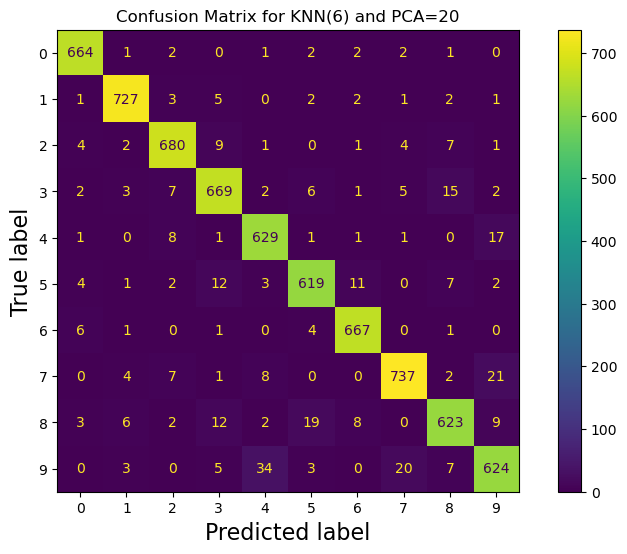

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       675
           1       0.97      0.98      0.98       744
           2       0.96      0.97      0.96       709
           3       0.96      0.94      0.95       712
           4       0.95      0.97      0.96       659
           5       0.96      0.96      0.96       661
           6       0.97      0.99      0.98       680
           7       0.96      0.95      0.95       780
           8       0.95      0.94      0.94       684
           9       0.94      0.92      0.93       696

    accuracy                           0.96      7000
   macro avg       0.96      0.96      0.96      7000
weighted avg       0.96      0.96      0.96      7000

SVM, time:36.5


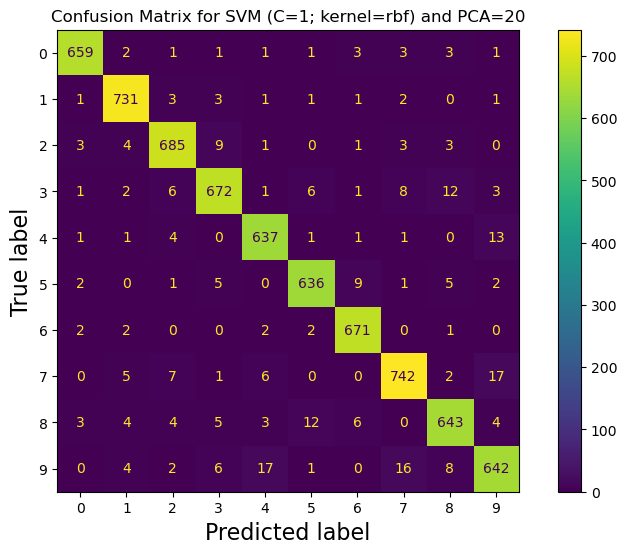

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       675
           1       0.96      0.98      0.97       744
           2       0.94      0.97      0.95       709
           3       0.93      0.95      0.94       712
           4       0.91      0.96      0.94       659
           5       0.95      0.95      0.95       661
           6       0.97      0.98      0.97       680
           7       0.96      0.95      0.95       780
           8       0.97      0.91      0.94       684
           9       0.95      0.87      0.91       696

    accuracy                           0.95      7000
   macro avg       0.95      0.95      0.95      7000
weighted avg       0.95      0.95      0.95      7000

Voting Classifier, time:43.0


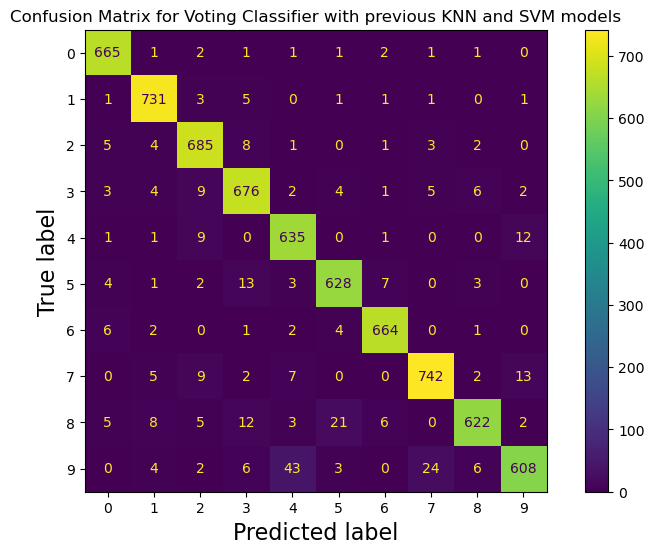

In [16]:
pca = PCA(n_components=20)
X_train_and_val_pca_scaled = pca.fit_transform(X_train_and_val_scaled)
X_test_pca_scaled = pca.transform(X_test_scaled)

start_time = time.time()
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_and_val_pca_scaled,y_train_and_val)
y_pred = knn.predict(X_test_pca_scaled)
print(f"KNN, time:{time.time()-start_time:.1f} s")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) # Compute the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Create a ConfusionMatrixDisplay object
disp.plot() # Plot the confusion matrix
plt.title("Confusion Matrix for KNN(6) and PCA=20")
plt.show() # Show the plot

start_time = time.time()
svm = SVC(C=1.0,kernel='rbf')
svm.fit(X_train_and_val_pca_scaled,y_train_and_val)
y_pred = svm.predict(X_test_pca_scaled)
print(f"SVM, time:{time.time()-start_time:.1f} s")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) # Compute the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Create a ConfusionMatrixDisplay object
disp.plot() # Plot the confusion matrix
plt.title("Confusion Matrix for SVM (C=1; kernel=rbf) and PCA=20")
plt.show() # Show the plot

start_time = time.time()
voting_clf = VotingClassifier([('knn',knn),('svm',svm)], voting='hard')
voting_clf.fit(X_train_and_val_pca_scaled,y_train_and_val)
y_pred = voting_clf.predict(X_test_pca_scaled)
print(f"Voting Classifier, time:{time.time()-start_time:.1f} s")
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred) # Compute the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm) # Create a ConfusionMatrixDisplay object
disp.plot() # Plot the confusion matrix
plt.title("Confusion Matrix for Voting Classifier with previous KNN and SVM models")
plt.show() # Show the plot
